In [1]:
import os
from tqdm.notebook import tqdm
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Load all simulation complexes

In [2]:
data_dir = "./E6/E6_VIA_MD"
xtc1_filename="prot_E6_via_complex_VIA_cluster_center_traj.xtc"
tpr_filename="prot_E6_via_complex_VIA_cluster_center.tpr"

xtc2_filename="prot_E6_via_complex_VIA_gppmd_extend_cluster_center.part0002.xtc"

E6_sildenafil_complex= mda.Universe(os.path.join(data_dir, tpr_filename),[os.path.join(data_dir, xtc1_filename),os.path.join(data_dir, xtc2_filename)], continuous=True)


In [3]:
data_dir = "./E6AP/E6AP_VIA_MD"
xtc_filename="prot_E6AP_VIA_complex_VIA_cluster_center_traj.xtc"
tpr_filename="prot_E6AP_VIA_complex_VIA_cluster_center_traj.tpr"

E6AP_sildenafil_complex= mda.Universe(os.path.join(data_dir, tpr_filename), os.path.join(data_dir, xtc_filename))


In [4]:
data_dir = "./E6_E6AP/E6E6AP_VIA_MD"
xtc_filename="prot_E6E6AP_VIA_complex_VIA_cluster_center_traj.xtc"
tpr_filename="prot_E6E6AP_VIA_complex_VIA_cluster_center_traj.tpr"

E6E6AP_sildenafil_complex= mda.Universe(os.path.join(data_dir, tpr_filename), os.path.join(data_dir, xtc_filename))

In [8]:
import pandas as pd
sildenafil_df = pd.DataFrame()

### Calculate all RMSD values and load in a dataframe

In [9]:
from MDAnalysis.analysis import rms
# Build the DataFrame directly by running the RMSD analysis for each complex
for universe in [E6_sildenafil_complex, E6AP_sildenafil_complex, E6E6AP_sildenafil_complex]:
    R_local = rms.RMSD(universe, universe, select='backbone', ref_frame=0)
    R_local.run(verbose=True)
    times = R_local.results.rmsd[:, 1]
    rmsd = R_local.results.rmsd[:, 2]
    # Create a DataFrame to hold the RMSD and later RMSF and Rg results
    complex_name = universe.trajectory.filename.split('/')[-2]  # Extract the complex name from the filename
    sildenafil_df[complex_name + '_Time'] = times
    sildenafil_df[complex_name + '_RMSD'] = rmsd


  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

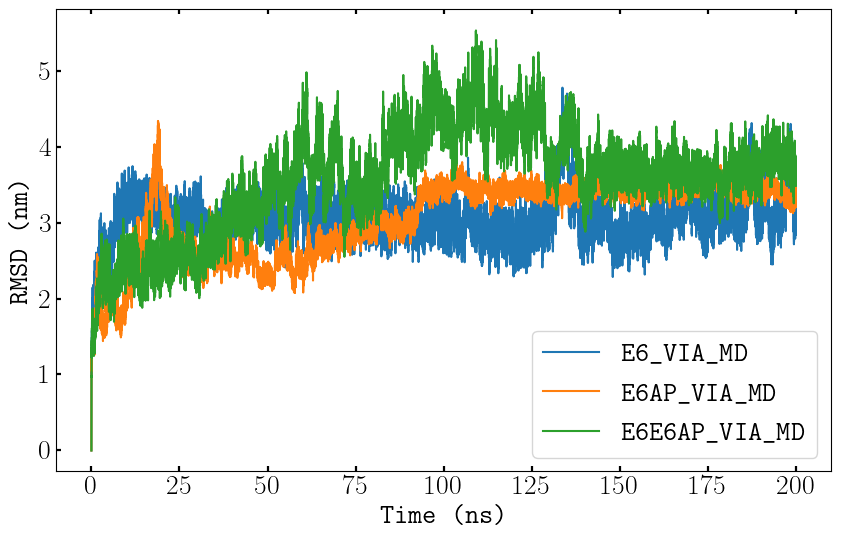

In [14]:
# Prepare and display the plot.
plt.figure(figsize=(10, 6))
plt.plot(sildenafil_df['E6_VIA_MD_Time']/1000, sildenafil_df['E6_VIA_MD_RMSD'], label='E6_VIA_MD')
plt.plot(sildenafil_df['E6AP_VIA_MD_Time']/1000, sildenafil_df['E6AP_VIA_MD_RMSD'], label='E6AP_VIA_MD')
plt.plot(sildenafil_df['E6E6AP_VIA_MD_Time']/1000, sildenafil_df['E6E6AP_VIA_MD_RMSD'], label='E6E6AP_VIA_MD')
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (nm)')
plt.legend()
plt.show()

### Calculate all RMSF and load in a dataframe

In [18]:
import pandas as pd
from MDAnalysis.analysis import rms

for universe in [E6_sildenafil_complex, E6AP_sildenafil_complex, E6E6AP_sildenafil_complex]:
    R_local = rms.RMSF(universe.select_atoms('backbone and name CA')).run(verbose=True)
    rmsf = R_local.results.rmsf
    # Create a DataFrame to hold the RMSF results
    complex_name = universe.trajectory.filename.split('/')[-2]  # Extract the complex name from the filename
    sildenafil_df[complex_name + '_RMSF'] = [rmsf] * len(sildenafil_df)
    sildenafil_df[complex_name + '_Resid'] = [universe.select_atoms('backbone and name CA').resids] * len(sildenafil_df)




  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

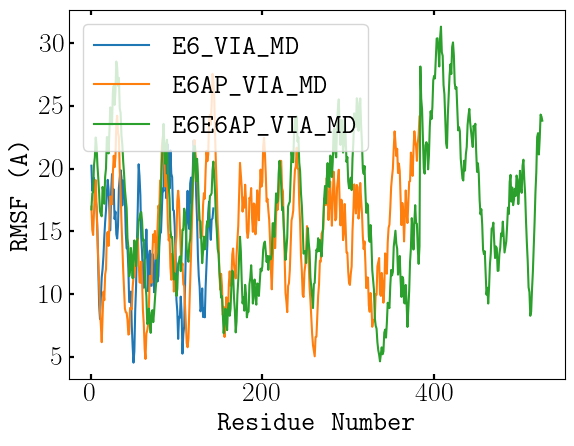

In [23]:
# Prepare and display the plot.
for complex_name in ['E6_VIA_MD', 'E6AP_VIA_MD', 'E6E6AP_VIA_MD']:
    plt.plot(sildenafil_df[complex_name + '_Resid'][0], sildenafil_df[complex_name + '_RMSF'][0], label=complex_name)
plt.xlabel('Residue Number')
plt.ylabel('RMSF (A)')
plt.legend()

### Calculate all Radii of Gyration and load in a dataframe 

In [24]:
from tqdm.notebook import tqdm
for universe in [E6_sildenafil_complex, E6AP_sildenafil_complex, E6E6AP_sildenafil_complex]:
    group = universe.select_atoms('protein')
    times = []
    rg = []
    for ts in tqdm(universe.trajectory):
        times.append(ts.time)
        rg.append(group.radius_of_gyration()/10)
    complex_name = universe.trajectory.filename.split('/')[-2]  # Extract the complex name from the filename    
    sildenafil_df[complex_name + 'Rg_Times'] = times
    sildenafil_df[complex_name + 'Rg'] = rg

  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

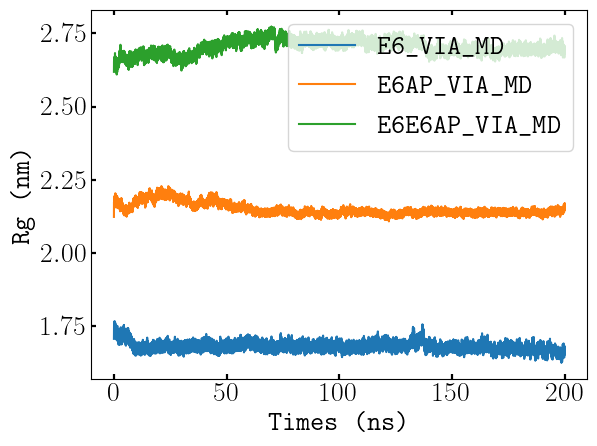

In [27]:
# Prepare and display the plot.
for complex_name in ['E6_VIA_MD', 'E6AP_VIA_MD', 'E6E6AP_VIA_MD']:
    plt.plot(sildenafil_df[complex_name + 'Rg_Times']/1000, sildenafil_df[complex_name + 'Rg'], label=complex_name)
plt.xlabel('Times (ns)')
plt.ylabel('Rg (nm)')
plt.legend()

### Number of hydrogen bonds between protein and ligand

In [6]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd

# Select the atoms for the analysis

# Create the HydrogenBondAnalysis object
hbs = HBA(universe=E6_sildenafil_complex,
          between=[
        ["protein", "resname VIA"],
        [ "resname VIA","protein"]
        ], # for protein-water hbonds
        d_h_cutoff=50.0, #This is set to an absurdly high value, which basically ignores this distance cutoff
        d_a_cutoff=3.5, d_h_a_angle_cutoff=30.0, #these are cutoffs used by GROMACS
    update_selections=False
    )
hbs.run(verbose=True)

  0%|          | 0/100001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:775: UserWarning: No hydrogen bonds were found given angle of 30.0 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYS and name O) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HIS and name ND1) or (resname HIS and name NE2) or (resname HIS and name O) or (resname ILE and name O) or (resname LEU and name O) or (re

In [7]:
for bond_idx in hbs.count_by_ids():
    donor_idx, hydrogen_idx, acceptor_idx, nframes = bond_idx
    donor_atom = E6_sildenafil_complex.atoms[donor_idx]
    hydrogen_atom = E6_sildenafil_complex.atoms[hydrogen_idx]
    acceptor_atom = E6_sildenafil_complex.atoms[acceptor_idx]
    hbond = f"{donor_atom.resid}-{donor_atom.resname}-{hydrogen_atom.name}::{acceptor_atom.name} , {nframes/ len(E6_sildenafil_complex.trajectory):.2%} frames"
    print(hbond)

107-GLN-HE21::O2 , 10.46% frames
107-GLN-HE22::O2 , 10.45% frames
107-GLN-HE21::O3 , 9.53% frames
107-GLN-HE22::O3 , 9.22% frames
129-ARG-HE::O2 , 2.48% frames
71-SER-HG::O3 , 1.51% frames
129-ARG-HH21::O2 , 1.35% frames
129-ARG-HH22::O2 , 0.93% frames
131-ARG-HH22::O2 , 0.57% frames
131-ARG-HH12::O2 , 0.56% frames
131-ARG-HH11::O2 , 0.54% frames
131-ARG-HH21::O2 , 0.53% frames
131-ARG-HH12::O3 , 0.33% frames
131-ARG-HH11::O3 , 0.33% frames
131-ARG-HH22::O3 , 0.09% frames
131-ARG-HH21::O3 , 0.08% frames
131-ARG-HE::O2 , 0.07% frames
74-SER-HG::O3 , 0.01% frames


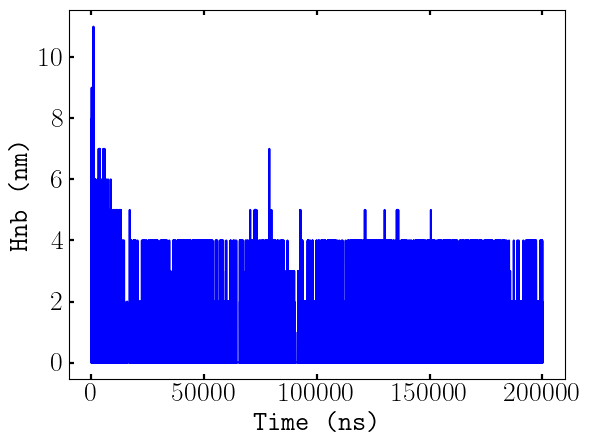

In [8]:
times = hbs.times
nhb = hbs.count_by_time()
E6_sildenafil_df['Nhb'] = nhb
nhb_df = pd.DataFrame({'Time': times, 'Nhb': nhb})
plt.plot(times, nhb, label='Nhb', color='blue')
plt.yticks([0,2,4,6,8,10])
plt.xlabel('Time (ns)')
plt.ylabel('Hnb (nm)')
plt.show()

The large number of hbonds in the beginning might be misleading, indicating that the same bond keeps getting counted multiple times due to shifting acceptor/donor residues.

### Hydrogen bonds from GROMACS

GROMACS hbond-legacy gave a better more sensible result for the hydrogen bonds, consistent with the VMD visualization where the ligand was rigidly bonded.

In [23]:
hbonds_df = pd.DataFrame()

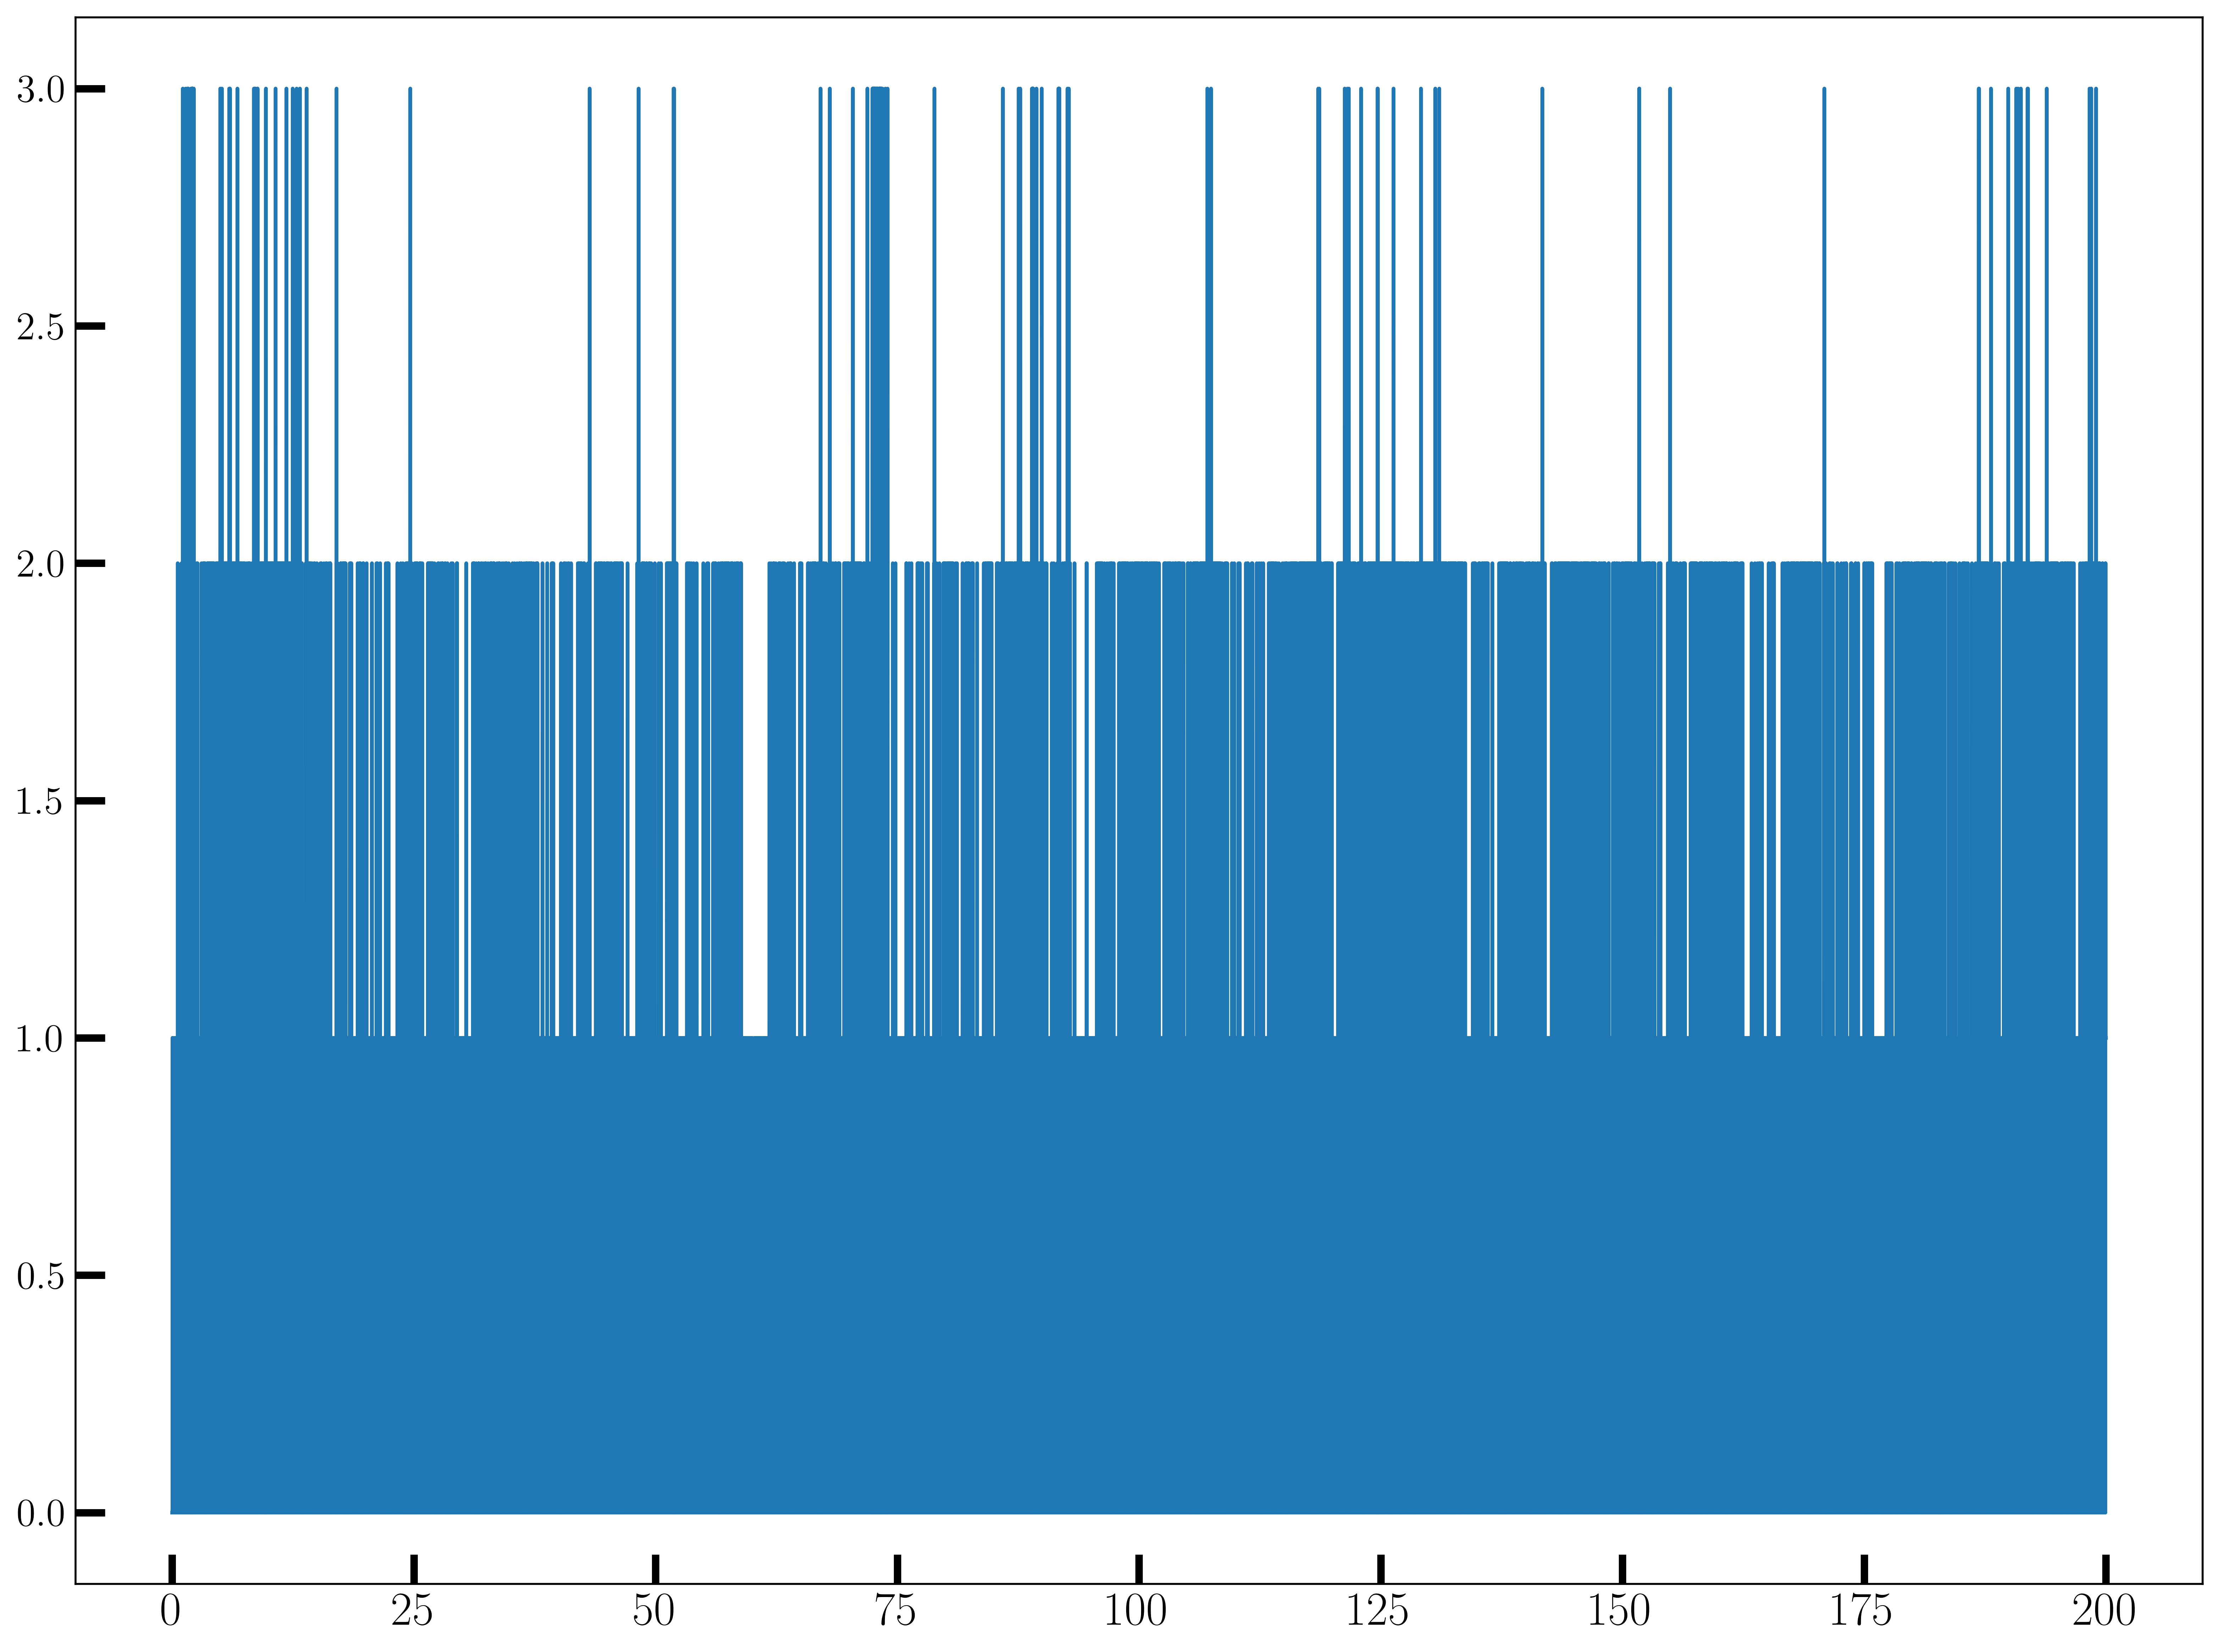

In [ ]:
import numpy as np
data_dir = "./E6/E6_VIA_MD"
gmx_hbondnum_file1 = os.path.join(data_dir, "hbnum_gromacs.xvg")
gmx_hbondnum_file2 = os.path.join(data_dir, "hbnum_extend.xvg")
with open(gmx_hbondnum_file1, 'r') as f:
    valid_lines = [line for line in f if not line.startswith(('#', '@'))]
data1 = np.loadtxt(valid_lines)
times1 = data1[:, 0]/1000
nhb1 = data1[:,1]

with open(gmx_hbondnum_file2, 'r') as f:
    valid_lines = [line for line in f if not line.startswith(('#', '@'))]
data2 = np.loadtxt(valid_lines)
times2 = data2[:, 0]/1000
nhb2 = data2[:,1]
hbonds_df['E6_Sildenafil_times_gmx'] = np.concatenate((times1, times2[1:]))
hbonds_df['E6_Sildenafil_Nhb_gmx'] = np.concatenate((nhb1, nhb2[1:]))

plt.plot(hbonds_df['E6_Sildenafil_times_gmx'], hbonds_df['E6_Sildenafil_Nhb_gmx'])

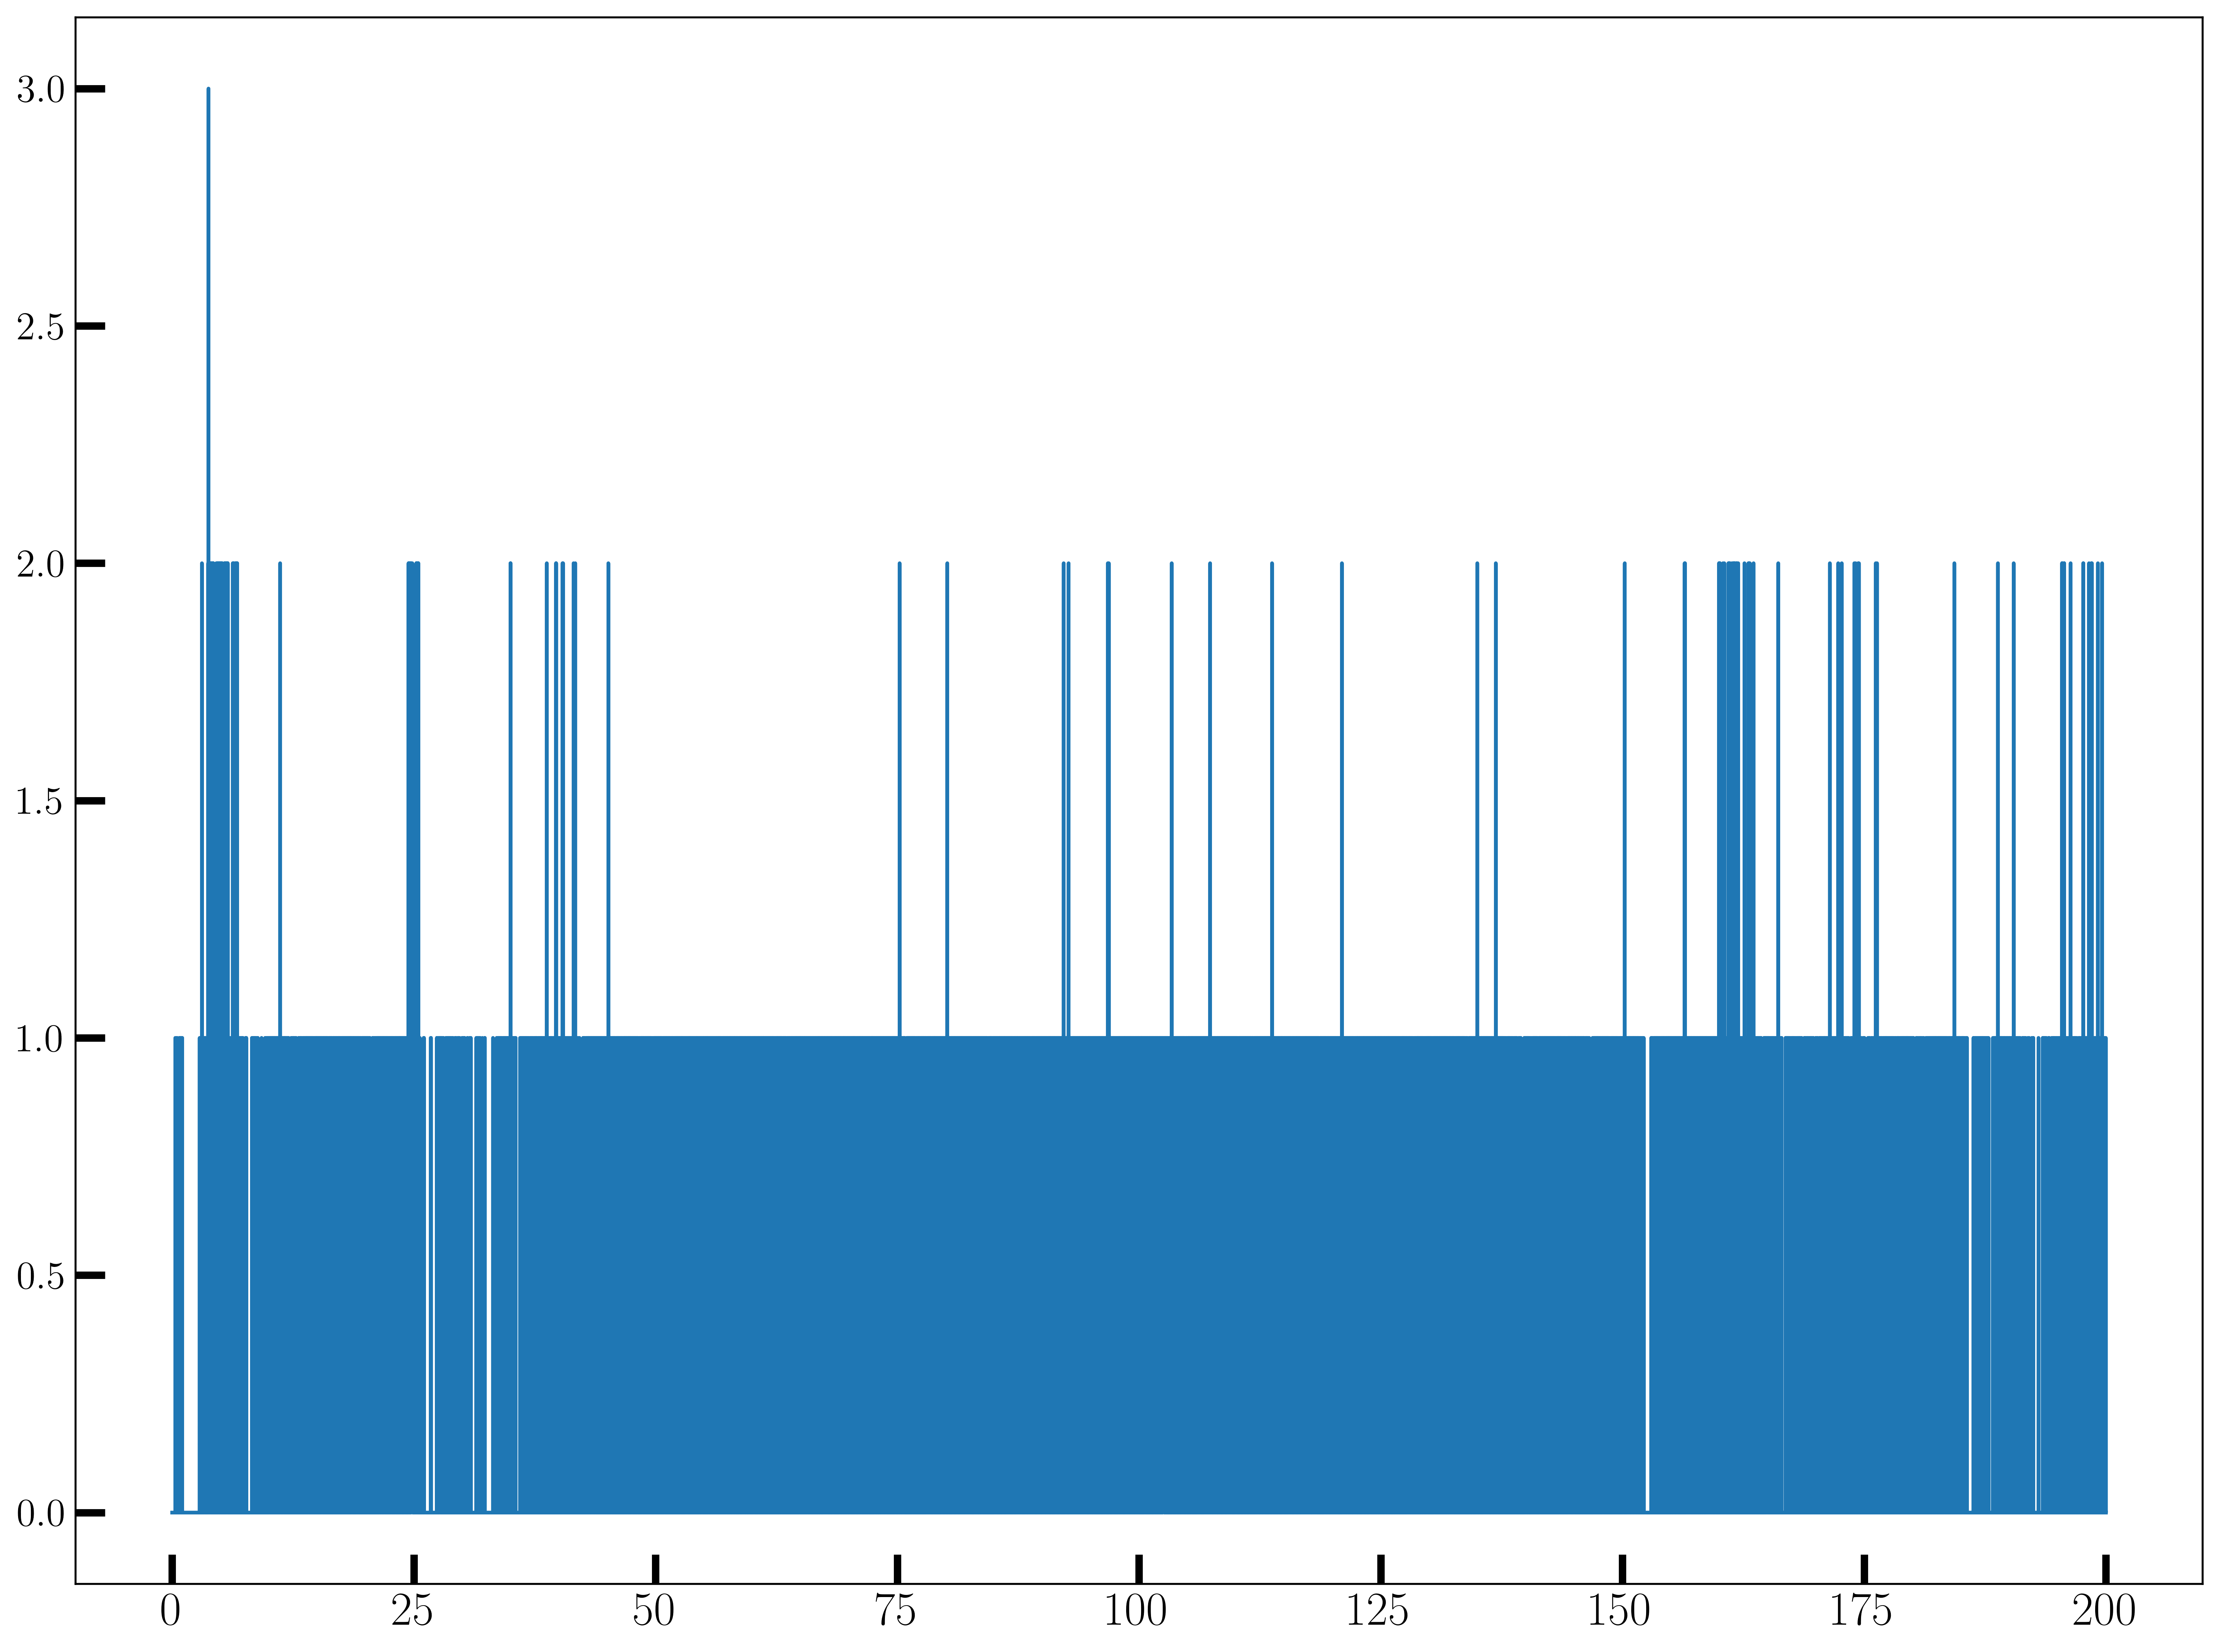

In [28]:
import numpy as np
data_dir = "./E6AP/E6AP_VIA_MD"
gmx_hbondnum_file = os.path.join(data_dir, "hbnum_gromacs.xvg")
with open(gmx_hbondnum_file, 'r') as f:
    valid_lines = [line for line in f if not line.startswith(('#', '@'))]
data = np.loadtxt(valid_lines)
times = data[:, 0]/1000
nhb = data[:,1]

target_length = hbonds_df.shape[0]
if len(times) < target_length:
    times = np.pad(times, (0, target_length - len(times)), mode='constant', constant_values=np.nan)
if len(nhb) < target_length:
    nhb = np.pad(nhb, (0, target_length - len(nhb)), mode='constant', constant_values=np.nan)
hbonds_df['E6AP_Sildenafil_times_gmx'] = times
hbonds_df['E6AP_Sildenafil_Nhb_gmx'] = nhb

plt.plot(hbonds_df['E6AP_Sildenafil_times_gmx'], hbonds_df['E6AP_Sildenafil_Nhb_gmx'])

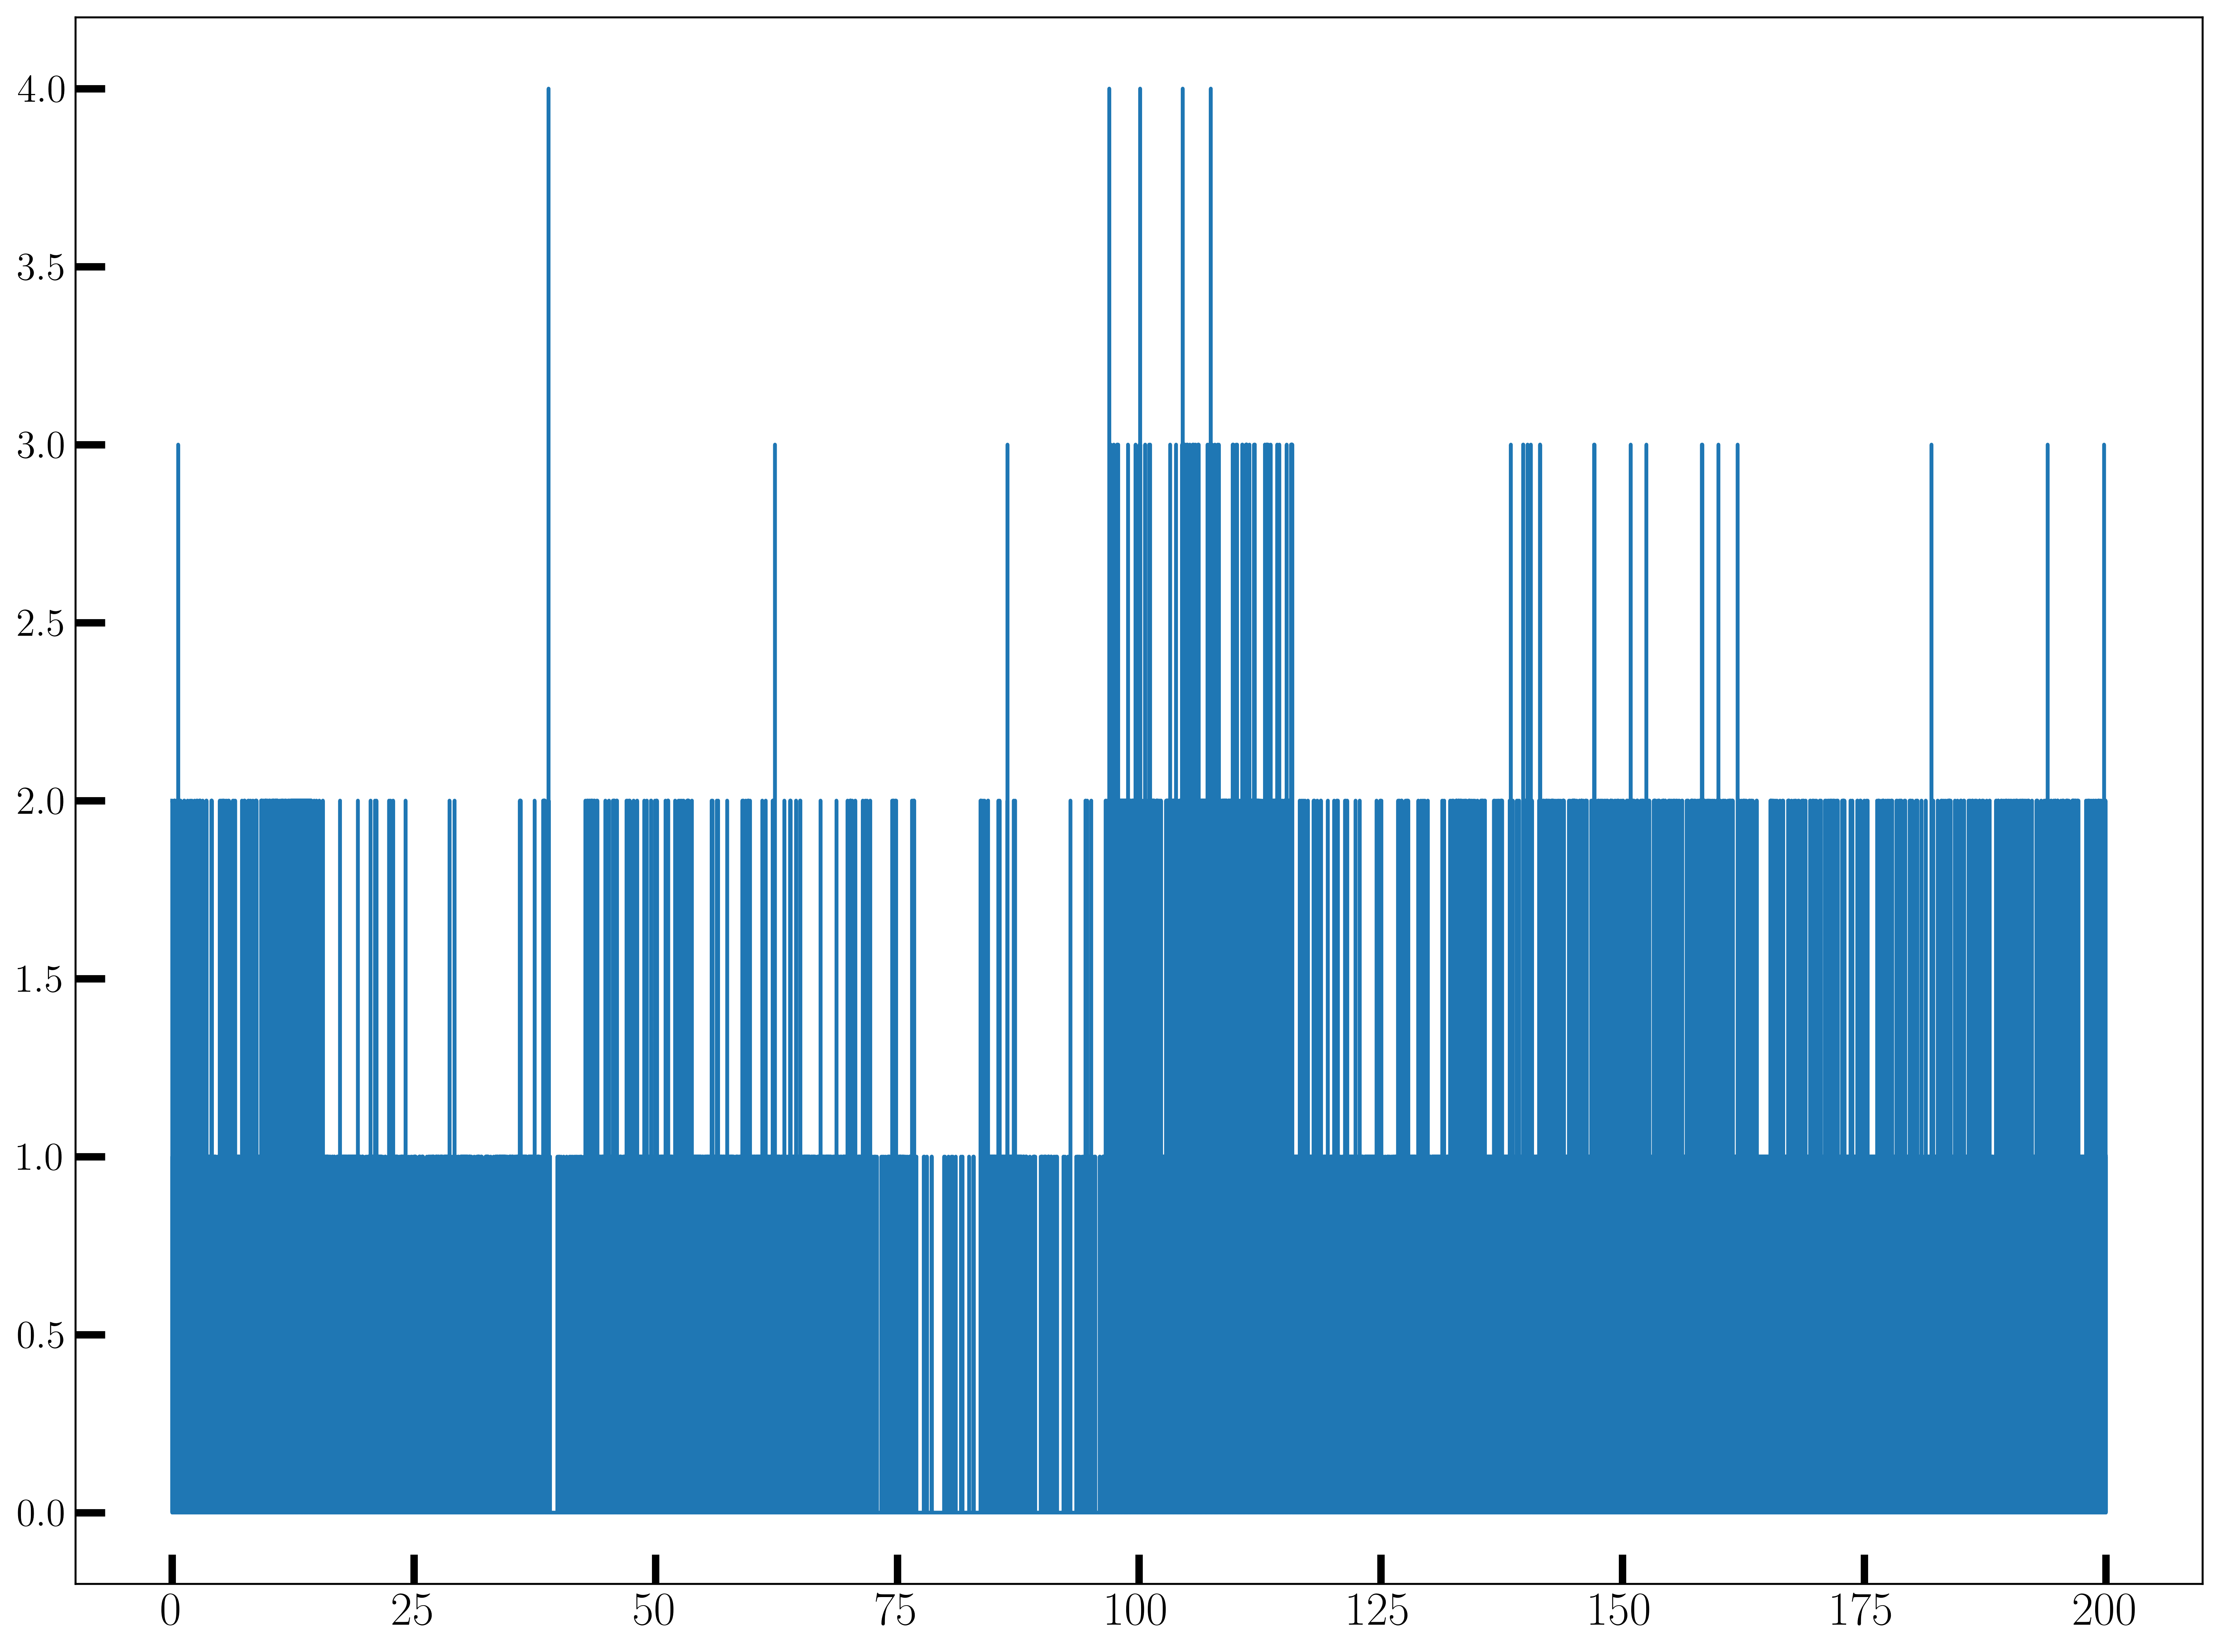

In [33]:
import numpy as np
data_dir = "./E6_E6AP/E6E6AP_VIA_MD"
gmx_hbondnum_file = os.path.join(data_dir, "hbnum_gromacs.xvg")
with open(gmx_hbondnum_file, 'r') as f:
    valid_lines = [line for line in f if not line.startswith(('#', '@'))]
data = np.loadtxt(valid_lines)
times = data[:, 0]/1000
nhb = data[:,1]

target_length = hbonds_df.shape[0]
if len(times) < target_length:
    times = np.pad(times, (0, target_length - len(times)), mode='constant', constant_values=np.nan)
if len(nhb) < target_length:
    nhb = np.pad(nhb, (0, target_length - len(nhb)), mode='constant', constant_values=np.nan)
hbonds_df['E6E6AP_Sildenafil_times_gmx'] = times
hbonds_df['E6E6AP_Sildenafil_Nhb_gmx'] = nhb

plt.plot(hbonds_df['E6E6AP_Sildenafil_times_gmx'], hbonds_df['E6E6AP_Sildenafil_Nhb_gmx'])

In [5]:
sildenafil_df = pd.read_pickle("sildenafil_df.pkl")
hbonds_df = pd.read_pickle("hbonds_df.pkl")
sildenafil_df, hbonds_df

(        E6_VIA_MD_Time  E6_VIA_MD_RMSD  E6AP_VIA_MD_Time  E6AP_VIA_MD_RMSD  \
 0                  0.0    6.385604e-07               0.0          0.000001   
 1                  2.0    4.918355e-01               2.0          0.646116   
 2                  4.0    6.816118e-01               4.0          0.736758   
 3                  6.0    6.306594e-01               6.0          0.750368   
 4                  8.0    7.547803e-01               8.0          0.824706   
 ...                ...             ...               ...               ...   
 99996         199994.0    3.029657e+00          199992.0          3.303815   
 99997         199996.0    3.025350e+00          199994.0          3.310976   
 99998         199998.0    3.017962e+00          199996.0          3.256159   
 99999         200000.0    3.041939e+00          199998.0          3.265861   
 100000        200002.0    3.090678e+00          200000.0          3.259589   
 
         E6E6AP_VIA_MD_Time  E6E6AP_VIA_MD_RMSD  \

### Plot everything

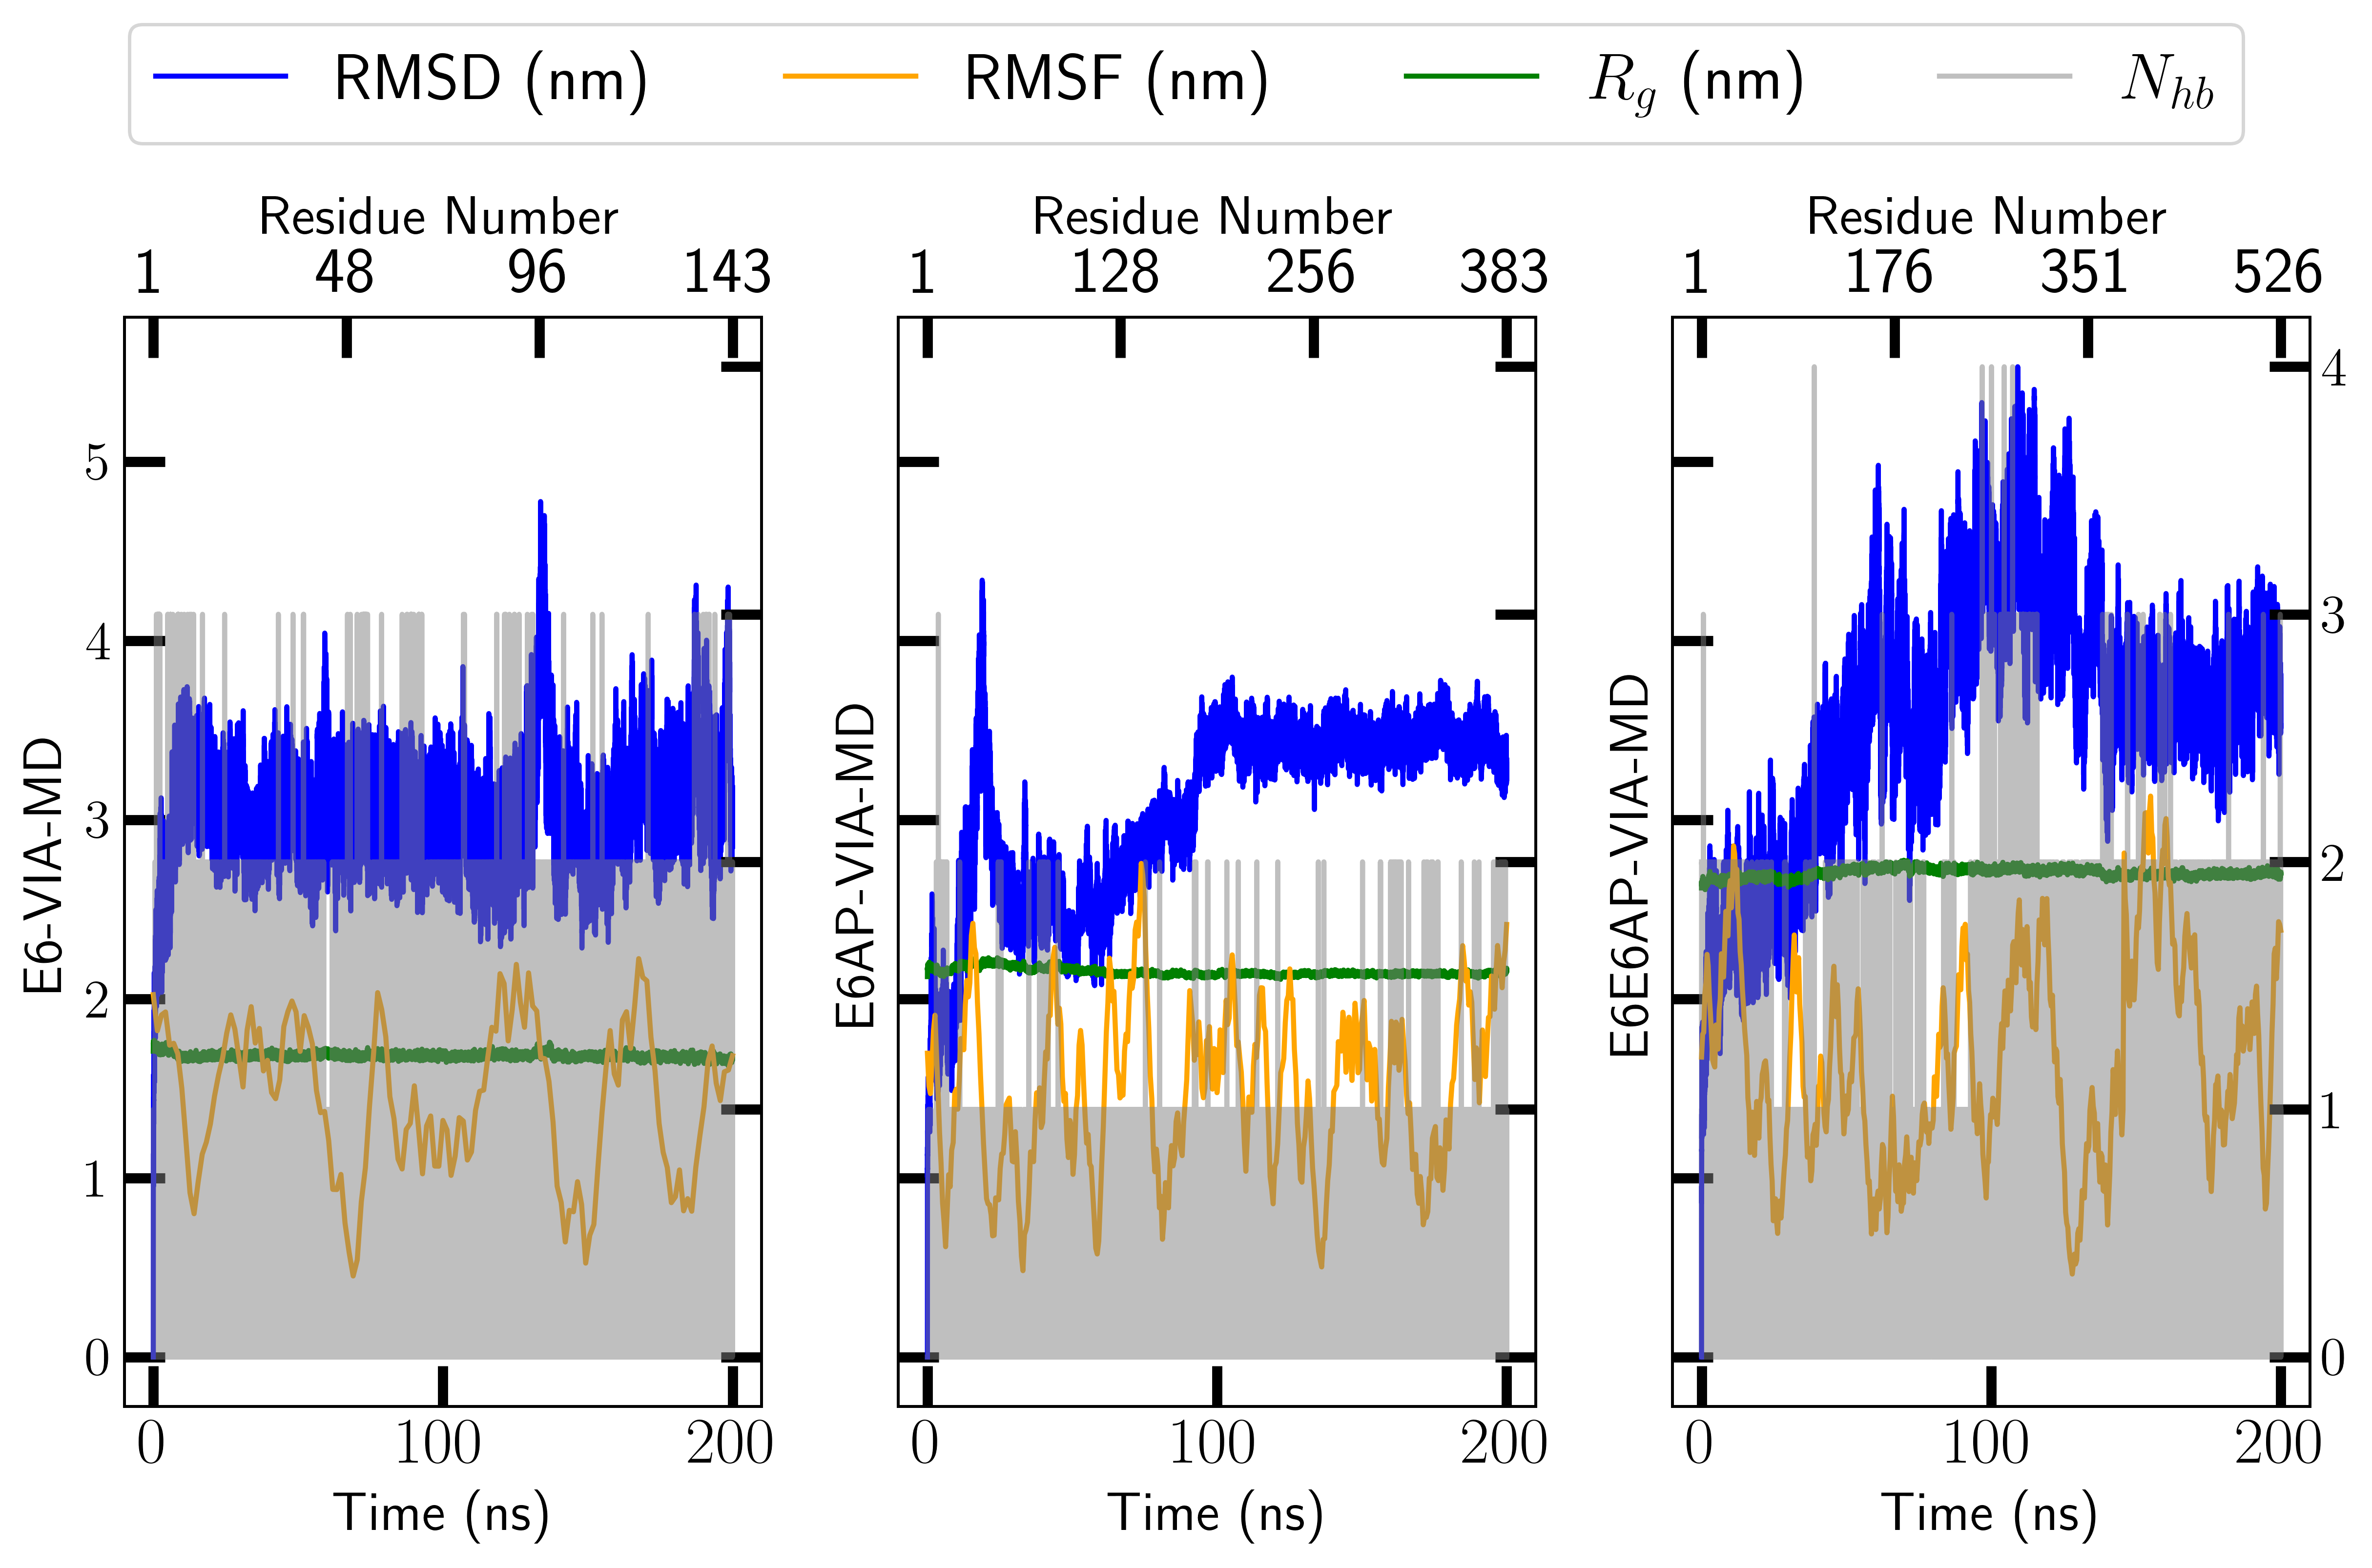

In [6]:
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(1, 3, figsize=(10, 6), sharey=True)


for i, complex_name in enumerate(['E6_VIA_MD', 'E6AP_VIA_MD', 'E6E6AP_VIA_MD']):
    axs[i].set_xlabel('Time (ns)')
    axs[i].set_ylabel(complex_name.replace('_', '-'))
    times = sildenafil_df[complex_name + '_Time']/1000
    rmsd = sildenafil_df[complex_name + '_RMSD']
    resids = sildenafil_df[complex_name + '_Resid'][0]
    rmsf = sildenafil_df[complex_name + '_RMSF'][0]
    axs[i].plot(times, rmsd, color='blue')
    ax_top = axs[i].twiny()
    
    ax_top.set_xlabel('Residue Number')
    ticks = np.linspace(resids[0], resids[-1], 4)
    
    #ticks = np.sort(np.append(ticks, extra_ticks))
    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(["{:.0f}".format(x) for x in ticks])
    ymax = ax_top.get_ylim()[1]
    #for resid in participating_resids:
    #    idx = np.where(resids == resid)[0][0]
    #    ax_top.vlines(x=resid, ymin=rmsf[idx]/10, ymax=ymax, color='green', linestyle='--', linewidth=1.5)
    ax_top.plot(resids, rmsf/10, color='orange')
    times = sildenafil_df[complex_name + 'Rg_Times']/1000
    rg = sildenafil_df[complex_name + 'Rg']
    axs[i].plot(times, rg, color='green')

for i, name in enumerate(["E6_Sildenafil","E6AP_Sildenafil" , "E6E6AP_Sildenafil"]):
    ax_right = axs[i].twinx()
    ax_right.plot(hbonds_df[name + '_times_gmx'], hbonds_df[name + '_Nhb_gmx'], color='gray', alpha=0.5)
    ax_right.set_ylim(-0.2, 4.2)
    if i != len(axs)-1:
        ax_right.set_yticklabels([])
    ax_right.yaxis.set_major_locator(MaxNLocator(integer=True))

line_rmsd = axs[1].lines[0]
line_rg = axs[1].lines[1]
line_rmsf = ax_top.lines[0]
line_nhb = ax_right.lines[0]
fig.legend([line_rmsd, line_rmsf, line_rg, line_nhb],
           ['RMSD (nm)', 'RMSF (nm)', r'$R_g$ (nm)', r'$N_{hb}$'],
           loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4)

plt.savefig("sildenafil_pp.svg", dpi=300, bbox_inches='tight')

In [43]:
sildenafil_df.to_pickle("sildenafil_df.pkl")
hbonds_df.to_pickle("hbonds_df.pkl")

## Refined Hydrogen bond analysis

In [ ]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd

# Select the atoms for the analysis

# Create the HydrogenBondAnalysis object
E6_Sildenafil_hbs_refined = HBA(universe=E6_sildenafil_complex,
          between=
        ["protein", "resname VIA"],
        d_h_cutoff=50.0, #This is set to an absurdly high value, which basically ignores this distance cutoff
        d_a_cutoff=3.5, d_h_a_angle_cutoff=30.0, #these are cutoffs used by GROMACS
    update_selections=False
    )
E6_Sildenafil_hbs_refined.run(verbose=True)

  0%|          | 0/100001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:775: UserWarning: No hydrogen bonds were found given angle of 30.0 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYS and name O) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HIS and name ND1) or (resname HIS and name NE2) or (resname HIS and name O) or (resname ILE and name O) or (resname LEU and name O) or (re

In [14]:
E6_Sildenafil_hbs_refined.count_by_type()

array([['ARG:N2', 'VIA:o', '7863'],
       ['GLN:N', 'VIA:o', '39656'],
       ['SER:OH', 'VIA:o', '1516']], dtype='<U21')

In [15]:
E6_Sildenafil_hbond_probs_dict = {}
for bond_idx in E6_Sildenafil_hbs_refined.count_by_ids():
    donor_idx, hydrogen_idx, acceptor_idx, nframes = bond_idx
    donor_atom = E6_sildenafil_complex.atoms[donor_idx]
    hydrogen_atom = E6_sildenafil_complex.atoms[hydrogen_idx]
    acceptor_atom = E6_sildenafil_complex.atoms[acceptor_idx]
    hbond = f"({donor_atom.resid}-{donor_atom.resname}){donor_atom.name}--{hydrogen_atom.name}::{acceptor_atom.name}(VIA)"
    E6_Sildenafil_hbond_probs_dict[hbond] = nframes / len(E6_sildenafil_complex.trajectory)

In [ ]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd

# Select the atoms for the analysis

# Create the HydrogenBondAnalysis object
E6AP_Sildenafil_hbs_refined = HBA(universe=E6AP_sildenafil_complex,
          between=
        ["protein", "resname VIA"],
        d_h_cutoff=50.0, #This is set to an absurdly high value, which basically ignores this distance cutoff
        d_a_cutoff=3.5, d_h_a_angle_cutoff=30.0, #these are cutoffs used by GROMACS
    update_selections=False
    )
E6AP_Sildenafil_hbs_refined.run(verbose=True)

E6AP_Sildenafil_hbond_probs_dict = {}
for bond_idx in E6AP_Sildenafil_hbs_refined.count_by_ids():
    donor_idx, hydrogen_idx, acceptor_idx, nframes = bond_idx
    donor_atom = E6AP_sildenafil_complex.atoms[donor_idx]
    hydrogen_atom = E6AP_sildenafil_complex.atoms[hydrogen_idx]
    acceptor_atom = E6AP_sildenafil_complex.atoms[acceptor_idx]
    hbond = f"({donor_atom.resid}-{donor_atom.resname}){donor_atom.name}--{hydrogen_atom.name}::{acceptor_atom.name}(VIA)"
    E6AP_Sildenafil_hbond_probs_dict[hbond] = nframes / len(E6AP_sildenafil_complex.trajectory)
E6AP_Sildenafil_hbs_refined.count_by_type()

  0%|          | 0/100001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:775: UserWarning: No hydrogen bonds were found given angle of 30.0 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ARG and name OC1) or (resname ARG and name OC2) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HIS and name ND1) or (resname HIS and name O) or (resname ILE and name O) or (resname LEU and name O) or (

array([['ARG:N2', 'VIA:o', '114'],
       ['ASN:N', 'VIA:c2', '181579'],
       ['ASN:N', 'VIA:o', '111772'],
       ['GLN:N', 'VIA:o', '83'],
       ['TRP:NA', 'VIA:o', '2']], dtype='<U21')

In [22]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd

# Select the atoms for the analysis

# Create the HydrogenBondAnalysis object
E6E6AP_Sildenafil_hbs_refined = HBA(universe=E6E6AP_sildenafil_complex,
          between=
        ["protein", "resname VIA"],
        d_h_cutoff=50.0, #This is set to an absurdly high value, which basically ignores this distance cutoff
        d_a_cutoff=3.5, d_h_a_angle_cutoff=30.0, #these are cutoffs used by GROMACS
    update_selections=False
    )
E6E6AP_Sildenafil_hbs_refined.run(verbose=True)

E6E6AP_Sildenafil_hbond_probs_dict = {}
for bond_idx in E6E6AP_Sildenafil_hbs_refined.count_by_ids():
    donor_idx, hydrogen_idx, acceptor_idx, nframes = bond_idx
    donor_atom = E6E6AP_sildenafil_complex.atoms[donor_idx]
    hydrogen_atom = E6E6AP_sildenafil_complex.atoms[hydrogen_idx]
    acceptor_atom = E6E6AP_sildenafil_complex.atoms[acceptor_idx]
    hbond = f"({donor_atom.resid}-{donor_atom.resname}){donor_atom.name}--{hydrogen_atom.name}::{acceptor_atom.name}(VIA)"
    E6E6AP_Sildenafil_hbond_probs_dict[hbond] = nframes / len(E6E6AP_sildenafil_complex.trajectory)
E6E6AP_Sildenafil_hbs_refined.count_by_type()

  0%|          | 0/100001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:775: UserWarning: No hydrogen bonds were found given angle of 30.0 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ARG and name OC1) or (resname ARG and name OC2) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYS and name O) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HIS and name ND1) or (resname HIS and name NE2) or (resname HIS and name O) or

array([['ARG:N2', 'VIA:c2', '59789'],
       ['ARG:N2', 'VIA:o', '97167'],
       ['GLN:N', 'VIA:o', '1993'],
       ['SER:OH', 'VIA:c2', '323'],
       ['SER:OH', 'VIA:o', '22195'],
       ['TYR:OH', 'VIA:c2', '1'],
       ['TYR:OH', 'VIA:o', '8876']], dtype='<U21')

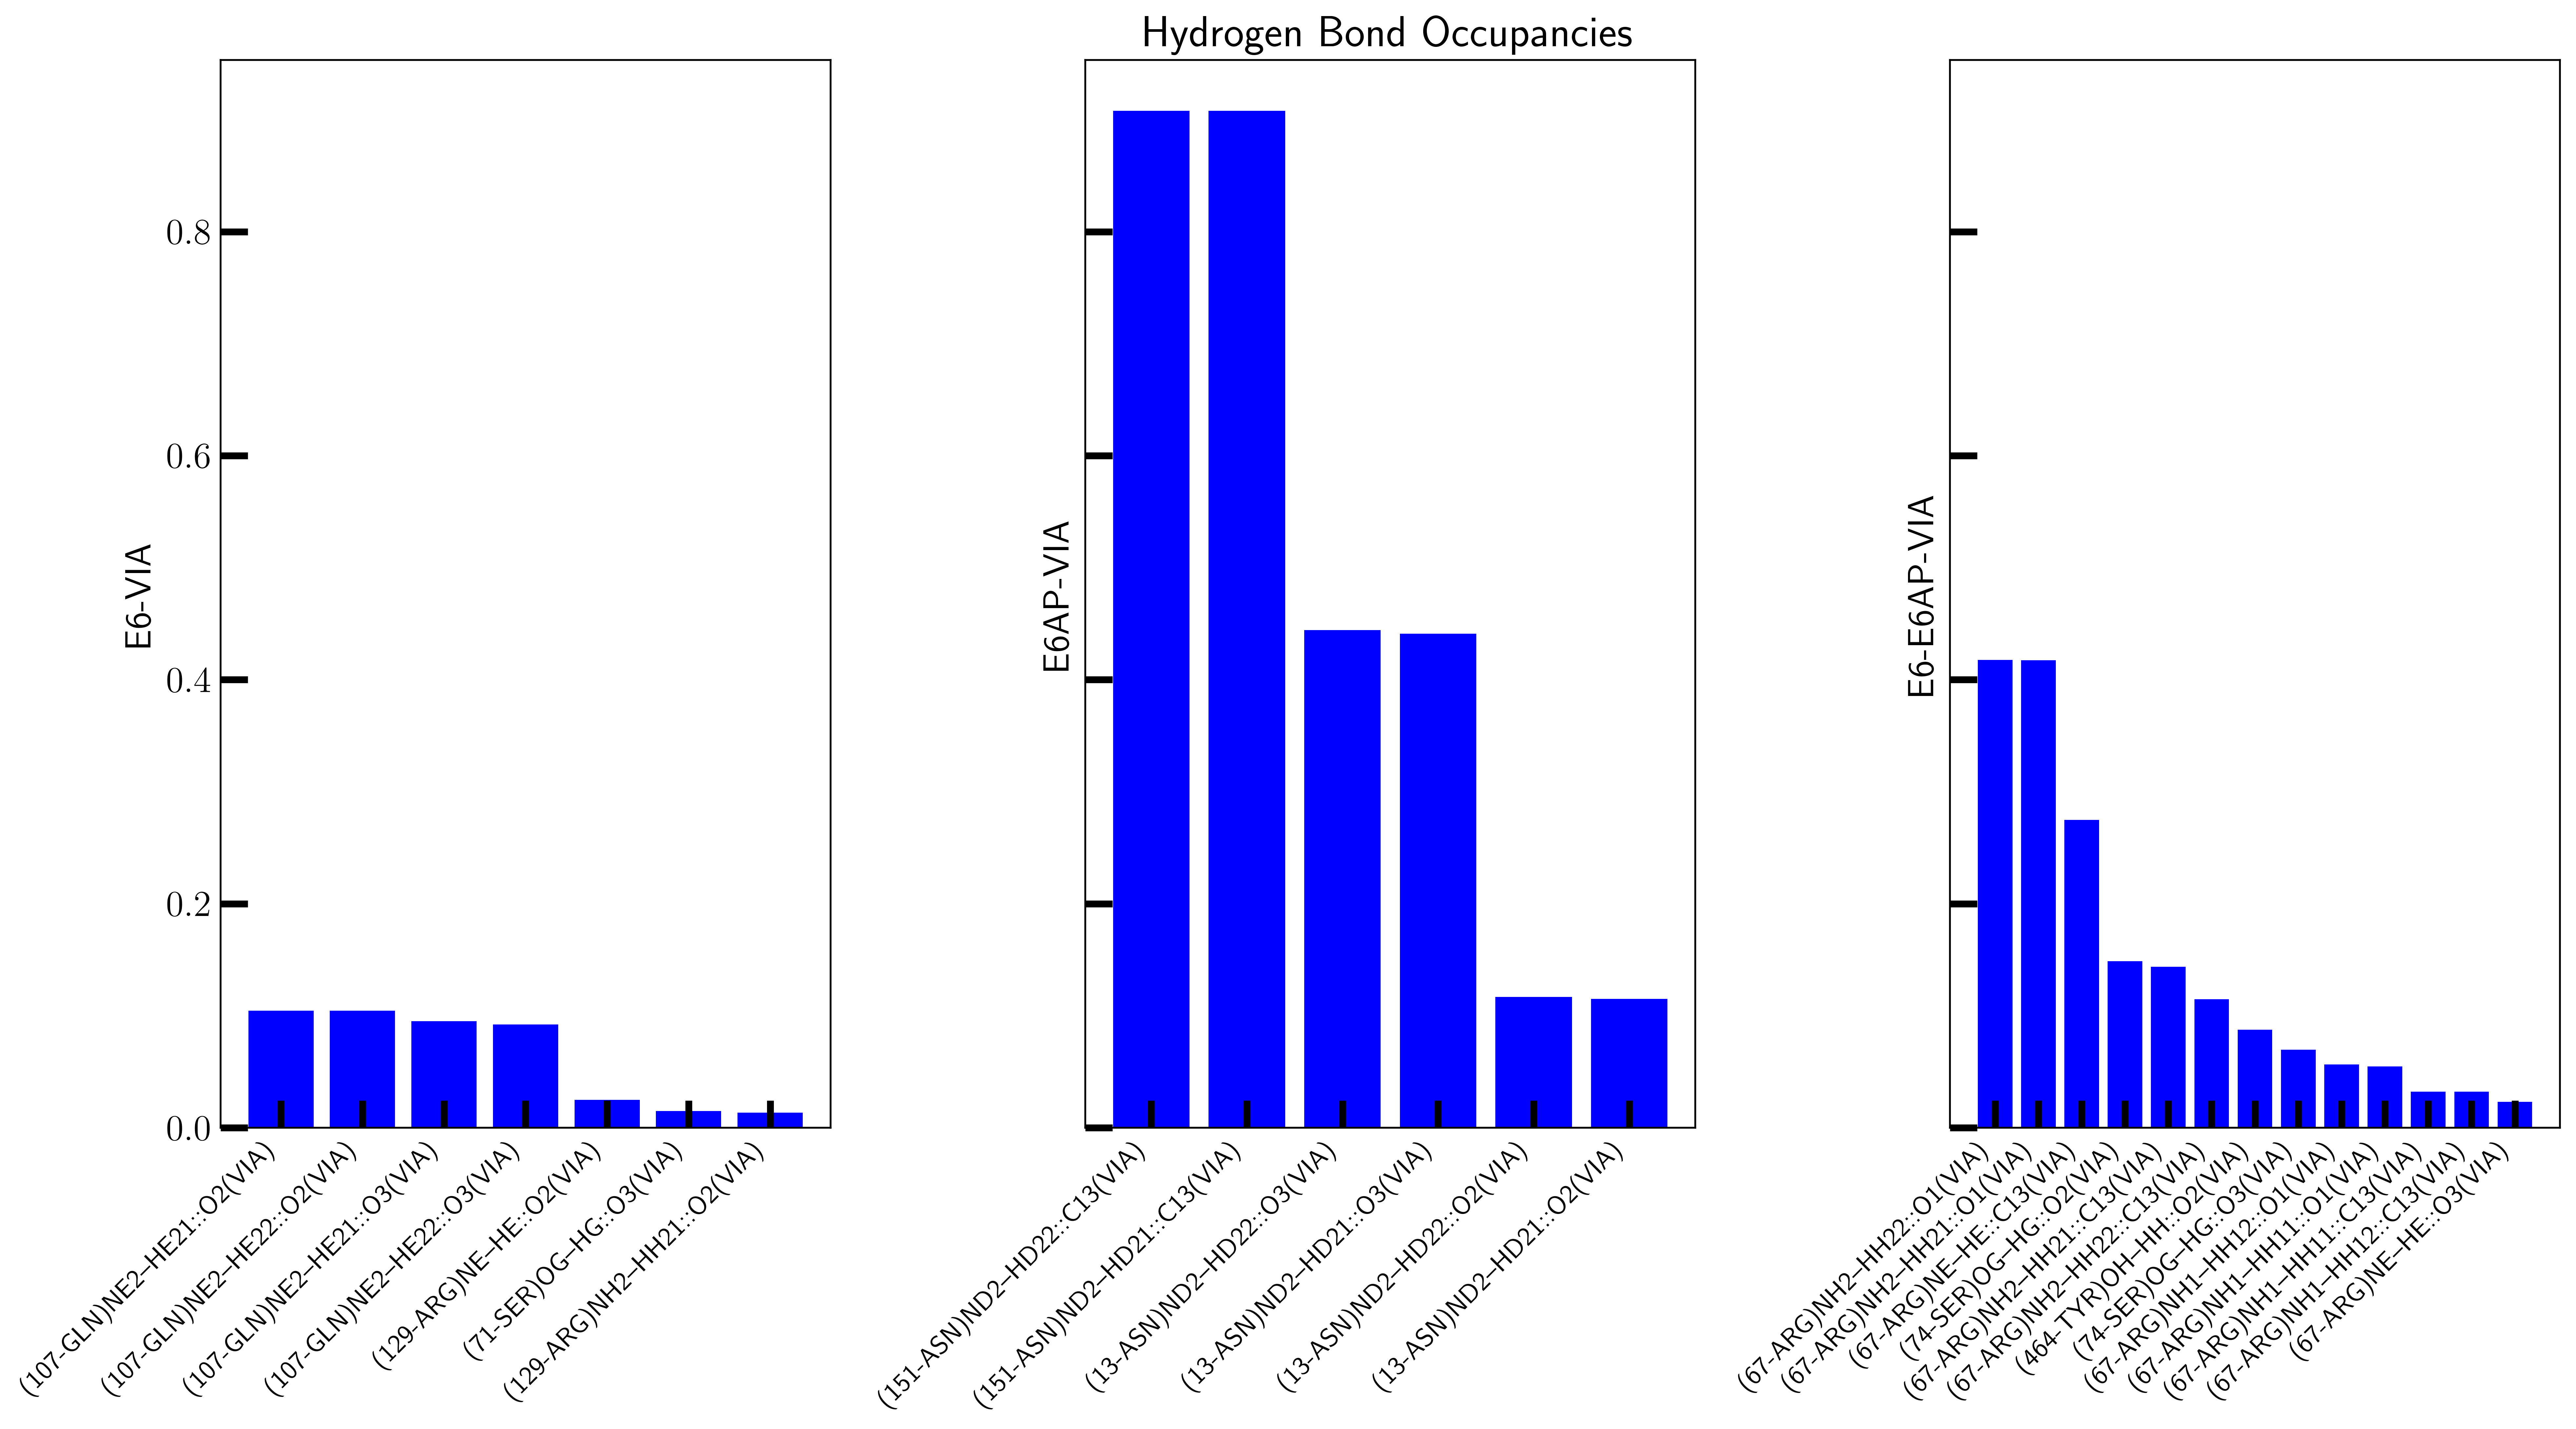

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(16, 9), sharey=True, tight_layout=True)

for i, dict in enumerate([E6_Sildenafil_hbond_probs_dict,\
                           E6AP_Sildenafil_hbond_probs_dict, E6E6AP_Sildenafil_hbond_probs_dict]):

    keys = list(dict.keys())
    values = list(dict.values())
    #filter hydrogen bonds with occupancies bigger than 1 percent
    filtered = {k: v for k, v in dict.items() if v >= 0.01}
    keys = list(filtered.keys())
    values = list(filtered.values())
    axs[i].bar(keys, values, color='blue')
    axs[i].set_ylabel(["E6-VIA", "E6AP-VIA", "E6-E6AP-VIA"][i])
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
        tick.set_fontsize(tick.get_fontsize() * 0.6)

axs[1].set_title("Hydrogen Bond Occupancies")
plt.savefig('Sildenafil_hbond_occupancies.svg', dpi=300, bbox_inches='tight')
plt.show()

### Refined Analysis of dominant hydrogen bonds

In [5]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd

# Select the atoms for the analysis

# Create the HydrogenBondAnalysis object
E6_Sildenafil_hbs_focussed = HBA(universe=E6_sildenafil_complex,
          between=
        ["resid 107 or resid 129", "resname VIA"],
        d_h_cutoff=50.0, #This is set to an absurdly high value, which basically ignores this distance cutoff
        d_a_cutoff=3.5, d_h_a_angle_cutoff=30.0, #these are cutoffs used by GROMACS
    update_selections=False
    )
E6_Sildenafil_hbs_focussed.run(verbose=True)

  0%|          | 0/100001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:775: UserWarning: No hydrogen bonds were found given angle of 30.0 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYS and name O) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HIS and name ND1) or (resname HIS and name NE2) or (resname HIS and name O) or (resname ILE and name O) or (resname LEU and name O) or (re

In [ ]:
E6_Sildenafil_hbs_focussed.count_by_type()

array([['ARG:N2', 'VIA:o', '4766'],
       ['GLN:N', 'VIA:o', '39656']], dtype='<U21')

In [ ]:
nhbonds = E6_Sildenafil_hbs_focussed.count_by_time()
max_val = np.max(nhbonds)
max_indices = np.where(nhbonds == max_val)[0]
print("Indices with maximum nhbonds:", max_indices)

#Dump the first frame
E6_sildenafil_complex.trajectory[0]
pdb_filename = f"E6_sildenafil_equilibrated.pdb"
protein = E6_sildenafil_complex.select_atoms("protein")
ligand = E6_sildenafil_complex.select_atoms("resname VIA")
combined = protein + ligand
combined.write(pdb_filename)

for idx in max_indices:
    # set the trajectory to the frame with maximum hydrogen bonds
    E6_sildenafil_complex.trajectory[idx]
    # get the corresponding time (convert from ps to ns)
    frame_time_ns = E6_sildenafil_complex.trajectory.time / 1000
    pdb_filename = f"E6_sildenafil_frame_{idx}_time_{frame_time_ns:.2f}ns.pdb"
    protein = E6_sildenafil_complex.select_atoms("protein")
    ligand = E6_sildenafil_complex.select_atoms("resname VIA")
    combined = protein + ligand
    combined.write(pdb_filename)
    # write out the current frame to a pdb file
    E6_sildenafil_complex.atoms.write(pdb_filename)

Indices with maximum nhbonds: [ 2915 39450]


In [13]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd

# Select the atoms for the analysis

# Create the HydrogenBondAnalysis object
E6AP_Sildenafil_hbs_focussed = HBA(universe=E6AP_sildenafil_complex,
          between=
        ["resid 13 or resid 151", "resname VIA"],
        d_h_cutoff=50.0, #This is set to an absurdly high value, which basically ignores this distance cutoff
        d_a_cutoff=3.5, d_h_a_angle_cutoff=30.0, #these are cutoffs used by GROMACS
    update_selections=False
    )
E6AP_Sildenafil_hbs_focussed.run(verbose=True)

  0%|          | 0/100001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:775: UserWarning: No hydrogen bonds were found given angle of 30.0 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ARG and name OC1) or (resname ARG and name OC2) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HIS and name ND1) or (resname HIS and name O) or (resname ILE and name O) or (resname LEU and name O) or (

In [18]:
E6AP_Sildenafil_hbs_focussed.count_by_type()

array([['ASN:N', 'VIA:c2', '181579'],
       ['ASN:N', 'VIA:o', '111772']], dtype='<U21')

In [16]:
nhbonds = E6AP_Sildenafil_hbs_focussed.count_by_time()
max_val = np.max(nhbonds)
max_indices = np.where(nhbonds == max_val)[0]
max_indices = [max_indices[0], max_indices[-1]] # Keep only the first and last indices
#Dump the first frame
E6AP_sildenafil_complex.trajectory[0]
pdb_filename = f"E6AP_sildenafil_equilibrated.pdb"
protein = E6AP_sildenafil_complex.select_atoms("protein")
ligand = E6AP_sildenafil_complex.select_atoms("resname VIA")
combined = protein + ligand
combined.write(pdb_filename)

for idx in max_indices:
    # set the trajectory to the frame with maximum hydrogen bonds
    E6AP_sildenafil_complex.trajectory[idx]
    # get the corresponding time (convert from ps to ns)
    frame_time_ns = E6AP_sildenafil_complex.trajectory.time / 1000
    pdb_filename = f"E6AP_sildenafil_frame_{idx}_time_{frame_time_ns:.2f}ns.pdb"
    protein = E6AP_sildenafil_complex.select_atoms("protein")
    ligand = E6AP_sildenafil_complex.select_atoms("resname VIA")
    combined = protein + ligand
    combined.write(pdb_filename)
    # write out the current frame to a pdb file
    E6AP_sildenafil_complex.atoms.write(pdb_filename)

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'

In [21]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd

# Select the atoms for the analysis

# Create the HydrogenBondAnalysis object
E6E6AP_Sildenafil_hbs_focussed = HBA(universe=E6E6AP_sildenafil_complex,
          between=
        ["resid 67", "resname VIA"],
        d_h_cutoff=50.0, #This is set to an absurdly high value, which basically ignores this distance cutoff
        d_a_cutoff=3.5, d_h_a_angle_cutoff=30.0, #these are cutoffs used by GROMACS
    update_selections=False
    )
E6E6AP_Sildenafil_hbs_focussed.run(verbose=True)

  0%|          | 0/100001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:775: UserWarning: No hydrogen bonds were found given angle of 30.0 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ARG and name OC1) or (resname ARG and name OC2) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYS and name O) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HIS and name ND1) or (resname HIS and name NE2) or (resname HIS and name O) or

In [22]:
E6E6AP_Sildenafil_hbs_focussed.count_by_type()

array([['ARG:N2', 'VIA:c2', '59789'],
       ['ARG:N2', 'VIA:o', '97167']], dtype='<U21')

In [23]:
nhbonds = E6E6AP_Sildenafil_hbs_focussed.count_by_time()
max_val = np.max(nhbonds)
max_indices = np.where(nhbonds == max_val)[0]
max_indices = [max_indices[0], max_indices[-1]] # Keep only the first and last indices
#Dump the first frame
E6E6AP_sildenafil_complex.trajectory[0]
pdb_filename = f"E6E6AP_sildenafil_equilibrated.pdb"
protein = E6E6AP_sildenafil_complex.select_atoms("protein")
ligand = E6E6AP_sildenafil_complex.select_atoms("resname VIA")
combined = protein + ligand
combined.write(pdb_filename)

for idx in max_indices:
    # set the trajectory to the frame with maximum hydrogen bonds
    E6E6AP_sildenafil_complex.trajectory[idx]
    # get the corresponding time (convert from ps to ns)
    frame_time_ns = E6E6AP_sildenafil_complex.trajectory.time / 1000
    pdb_filename = f"E6E6AP_sildenafil_frame_{idx}_time_{frame_time_ns:.2f}ns.pdb"
    protein = E6E6AP_sildenafil_complex.select_atoms("protein")
    ligand = E6E6AP_sildenafil_complex.select_atoms("resname VIA")
    combined = protein + ligand
    combined.write(pdb_filename)
    # write out the current frame to a pdb file
    E6E6AP_sildenafil_complex.atoms.write(pdb_filename)

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'